In [145]:
# Importing the libraries
import numpy as np
import pandas as pd
import seaborn as sns
from matplotlib import pyplot as plt
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import f1_score, roc_auc_score
from xgboost import XGBClassifier
from sklearn.model_selection import train_test_split

In [146]:
# Load the data
data = pd.read_csv('payment-practices.csv')

In [147]:
# Drop columns that are not useful for the model
columns_to_drop = ['Report Id','Start date', 'End date', 'Filing date', 'Company', 'Company number','URL']
data = data.drop(columns=columns_to_drop)

80th Quantile =  47.0


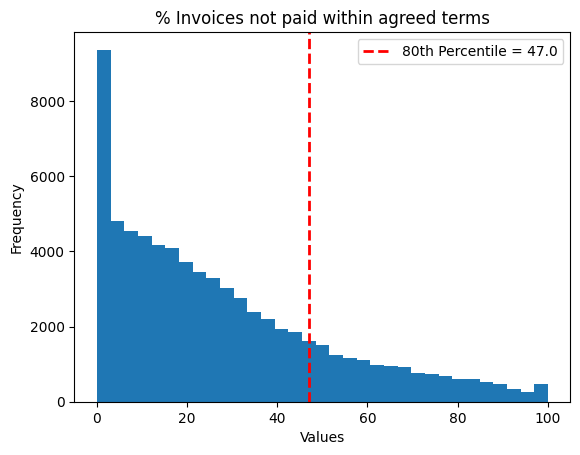

In [148]:
# Bar plot for '% Invoices not paid within agreed terms' and 80th percentile
percentile_80 = np.percentile(data['% Invoices not paid within agreed terms'].dropna(), 80)
print('80th Quantile = ',percentile_80)

plt.hist(data['% Invoices not paid within agreed terms'],bins=33)
plt.axvline(x=percentile_80, color='red', linestyle='dashed', linewidth=2, label='80th Percentile = '+str(percentile_80))

plt.xlabel('Values')
plt.ylabel('Frequency')
plt.title('% Invoices not paid within agreed terms')

# Show the plot
plt.legend()
plt.show()

In [149]:
# assigning types of features
numerical_features = data.select_dtypes(include=['int64', 'float64']).columns
categorical_features = data.select_dtypes(include=['object','bool']).columns
missing_data_cols = [i for i in categorical_features if data[i].isnull().sum() > 0]
non_missing_cat = [i for i in categorical_features if i not in missing_data_cols]

In [150]:
# Missing data
missing_data = pd.DataFrame({'total_missing': data.isnull().sum(), 'perc_missing': (data.isnull().mean())*100})
missing_data

,total_missing,perc_missing
Payments made in the reporting period,14673,18.888789
Average time to pay,6859,8.829701
% Invoices paid within 30 days,6859,8.829701
% Invoices paid between 31 and 60 days,6859,8.829701
% Invoices paid later than 60 days,6859,8.829701
% Invoices not paid within agreed terms,6708,8.635316
Shortest (or only) standard payment period,6708,8.635316
Longest standard payment period,30562,39.342954
Maximum contractual payment period,6708,8.635316
Payment terms have changed,6708,8.635316


Handling missing data

In [151]:
# Imputing the Continuous missing values with Mean
for var in numerical_features:
    data.fillna({var:data[var].mean()}, inplace=True)

In [152]:
# Imputing the Categorical missing values with KNN Imputer
from sklearn.impute import KNNImputer

# Create an instance of KNNImputer
imputer = KNNImputer()

# Impute the missing values in the columns specified in missing_data_cols
data_imputed = imputer.fit_transform(data)

# Convert the imputed data back to a DataFrame
data_imputed = pd.DataFrame(data_imputed,columns=data.columns)

data = data_imputed


In [154]:
#missing data
missing_data = pd.DataFrame({'total_missing': data.isnull().sum(), 'perc_missing': (data.isnull().mean())*100})
missing_data

,total_missing,perc_missing
Payments made in the reporting period,0,0.0
Average time to pay,0,0.0
% Invoices paid within 30 days,0,0.0
% Invoices paid between 31 and 60 days,0,0.0
% Invoices paid later than 60 days,0,0.0
% Invoices not paid within agreed terms,0,0.0
Shortest (or only) standard payment period,0,0.0
Longest standard payment period,0,0.0
Maximum contractual payment period,0,0.0
Payment terms have changed,0,0.0


In [155]:
# Creating target column 'flag' based on the 80th percentile
data['flag'] = 0
data.loc[data['% Invoices not paid within agreed terms'] > percentile_80, 'flag'] = 1
data.drop(columns=['% Invoices not paid within agreed terms'],inplace=True)

<Axes: >

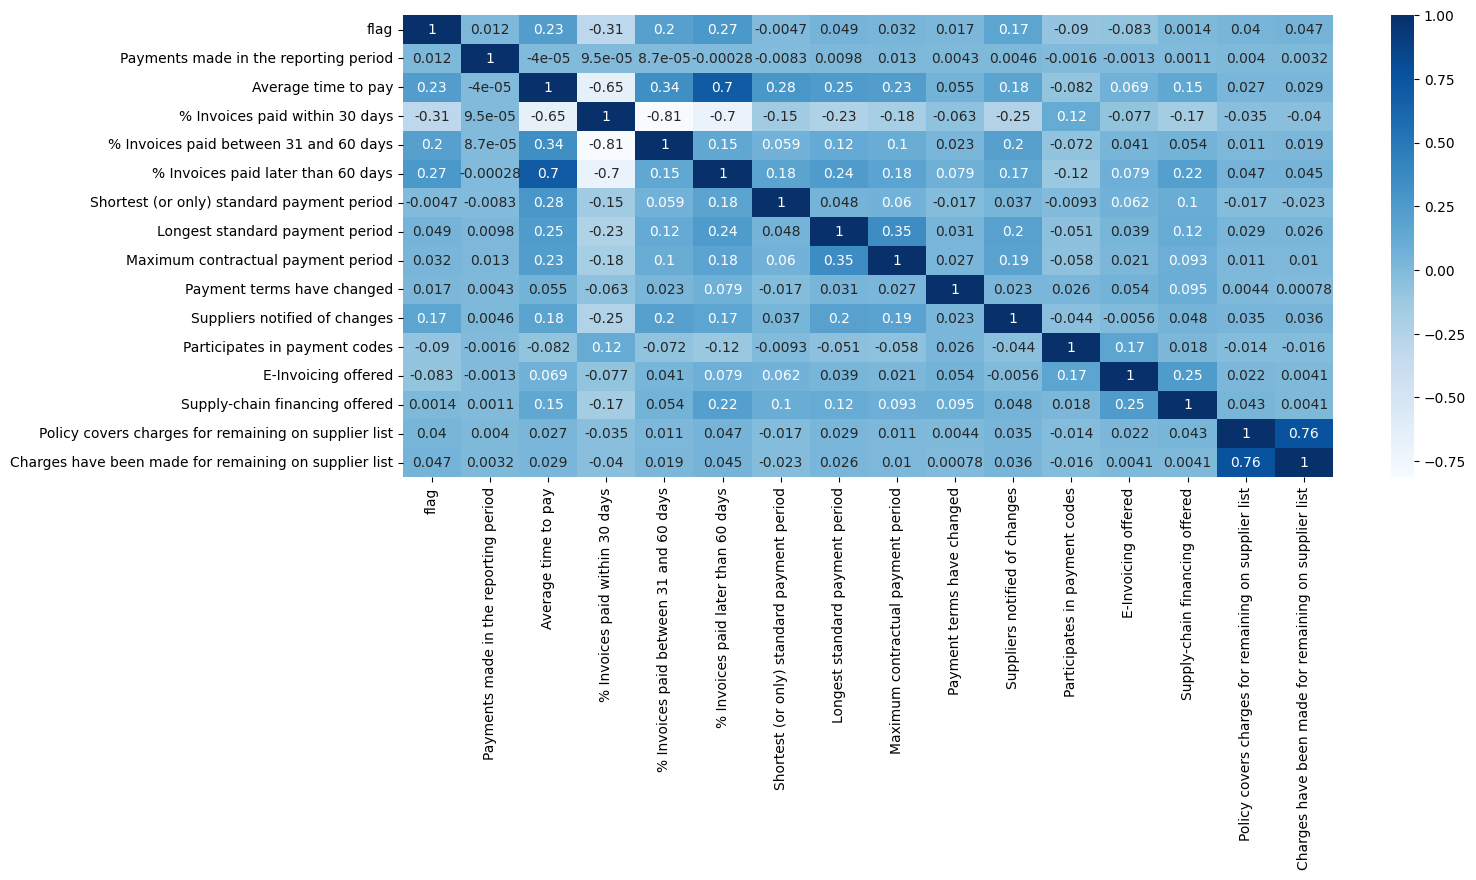

In [156]:
# Correlation Analysis
new_order=[     'flag',
                'Payments made in the reporting period', 'Average time to pay',
                '% Invoices paid within 30 days',
                '% Invoices paid between 31 and 60 days',
                '% Invoices paid later than 60 days',
                'Shortest (or only) standard payment period',
                'Longest standard payment period', 'Maximum contractual payment period',
                'Payment terms have changed', 'Suppliers notified of changes',
                'Participates in payment codes', 'E-Invoicing offered',
                'Supply-chain financing offered',
                'Policy covers charges for remaining on supplier list',
                'Charges have been made for remaining on supplier list']
plt.figure(figsize=(15, 6))
sns.heatmap(data.reindex(columns=new_order).corr(),annot=True,cmap='Blues')

In [157]:
# Dropping the Highly correlated Features
data1 = data.drop(columns=[ '% Invoices paid within 30 days', 
                            '% Invoices paid later than 60 days',
                            'Suppliers notified of changes',
                            'Policy covers charges for remaining on supplier list'])

In [158]:
# Splitting the data into train and test
X_train, X_test, y_train, y_test = train_test_split(data1.drop(columns=['flag']), data1['flag'], test_size=0.3, random_state=42)

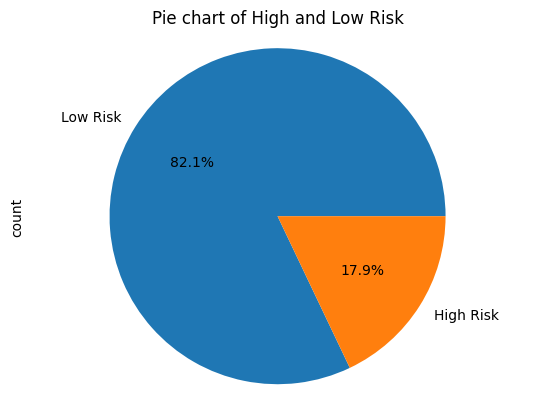

In [159]:
# Pie chart of High and Low Risk before Sampling
y_train.value_counts().plot.pie(autopct='%1.1f%%',labels=['Low Risk','High Risk'])
plt.axis('equal')
plt.title('Pie chart of High and Low Risk')
plt.show()

In [160]:
# Implemeting the RandomOverSampler
from imblearn.over_sampling import RandomOverSampler

# Create an instance of RandomOverSampler
oversampler = RandomOverSampler()

# Perform random oversampling on X_train and y_train
X_train_oversampled, y_train_oversampled = oversampler.fit_resample(X_train, y_train)


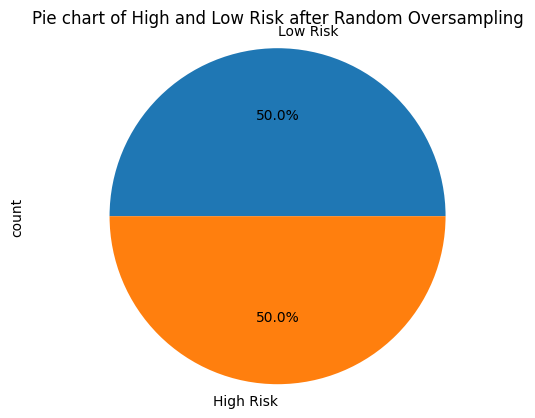

In [161]:
# pie chart of High and Low Risk after Random Oversampling
y_train_oversampled.value_counts().plot.pie(autopct='%1.1f%%',labels=['Low Risk','High Risk'])
plt.axis('equal')
plt.title('Pie chart of High and Low Risk after Random Oversampling')
plt.show()

XGBoost

In [162]:
params = {
    'learning_rate': 0.01,
    'max_depth': 10,
    'min_child_weight': 1,
    'subsample': 0.85,
    'n_estimators': 900,
} 

xgb_clf = XGBClassifier(**params)

xgb_clf.fit(X_train_oversampled, y_train_oversampled)

y_pred = xgb_clf.predict(X_test)

print('XGBoost model accuracy score: {0:0.4f}'. format(accuracy_score(y_test, y_pred)))
f1 = f1_score(y_test, y_pred)
print('F1 Score:', f1)

# Calculate AUC
auc = roc_auc_score(y_test, y_pred)
print('AUC:', auc)

XGBoost model accuracy score: 0.7760
F1 Score: 0.5431472081218274
AUC: 0.7632006661011483


Random Forest

In [163]:
# Create an instance of the RandomForestClassifier
model = RandomForestClassifier(random_state=42)

# Fit the model to the data
model.fit(X_train, y_train)

# Make predictions on the data
predictions = model.predict(X_test)

# Calculate accuracy
accuracy = accuracy_score(y_test, predictions)

print("Random Forest Accuracy:", accuracy)

f1 = f1_score(y_test, predictions)
print('F1 Score:', f1)

# Calculate AUC
auc = roc_auc_score(y_test, predictions)
print('AUC:', auc)

Random Forest Accuracy: 0.8454838017592792
F1 Score: 0.49245947850599014
AUC: 0.6785629055532427
